In [1]:
# study the independent 2D problem - use only the 3 month cycles over the 6 month period + analyze error of multiple models.
# can they at least find the "Extreme" cases?

# NOTE - don't separate feature variables and target variables when it's unnecessary. it's easier to filter data (and 
# have the corresponding targets) when it's all contained in a single dataframe

In [2]:
import pandas as pd
import numpy as np
import os.path 
import pandas_datareader.data as web
import datetime 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import gmean

%matplotlib inline
plt.style.use('ggplot')

In [3]:
# (change discrimentation threshold for classes - use absolute value of return)

timelinedata = pd.read_csv('timeline-data/IBM-timeline-data.csv')

features = pd.read_csv('timeline-data/IBM-features.csv')
targets0 = pd.read_csv('timeline-data/IBM-targets.csv')
targets = targets0.apply(lambda x: x > 0).astype(int)

In [4]:
# historical price data suggests an approximate random walk. (about as many bullish months as bearish)

targets.sum()/len(targets)

0    0.537953
dtype: float64

In [5]:
# net return over each half (3 month period)

threemonthreturns = []

for i in range(len(features)):
    threemonthreturns.append([np.prod(features.iloc[i][:63]+1)-1,np.prod(features.iloc[i][63:]+1)-1])
    
threemonthreturns = np.array(threemonthreturns)

In [6]:
final_features = pd.DataFrame(threemonthreturns)

In [7]:
features_train = final_features[:-1000]
targets_train = targets[:-1000]

features_test = final_features[-1000:]
targets_test = targets[-1000:]

Text(0,0.5,'Return in 2nd half')

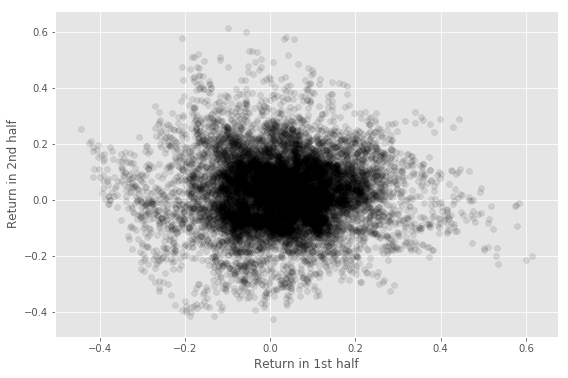

In [8]:
fig, ax = plt.subplots(1,1,figsize=(9,6))

ax.scatter(features_train[0],features_train[1],color='k',alpha=0.1)
ax.set_xlabel('Return in 1st half')
ax.set_ylabel('Return in 2nd half')

(0, 0.6)

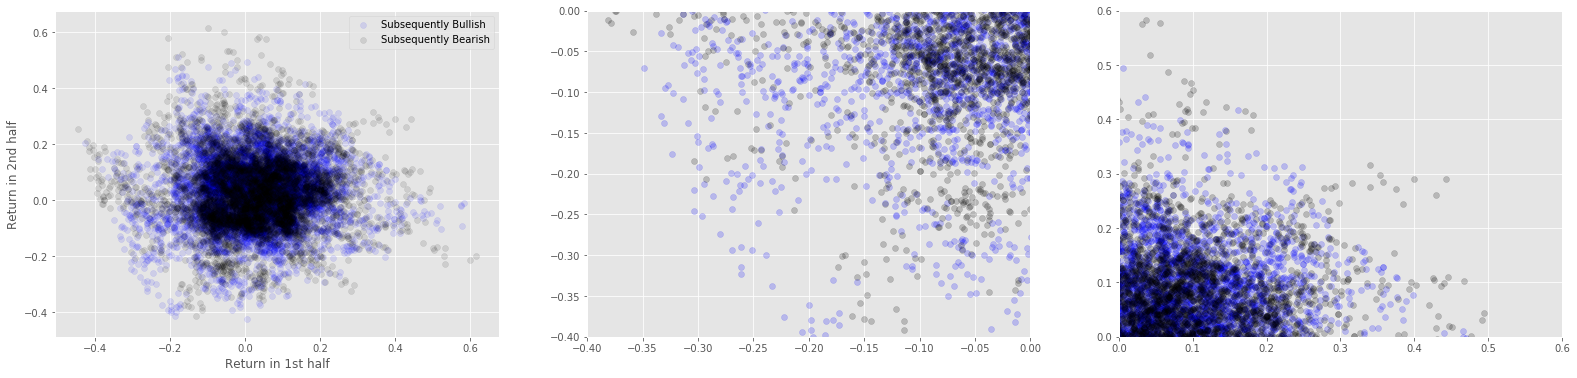

In [9]:
# there seem to be more blue points in the bottom left corner (back-to-back bearish 3-month periods) than black points.
# suggests evidence for mean reversion? the predictive model will probably do much better if we focus only on the 
# extreme cases. (all the overlap/noise in the middle of the plot 'frustrates' the model from finding signal of outliers)
# need to develop a bigger dataset of "extreme cases" if we take that approach (look at a bigger selection of stocks)

fig, (ax,ax1,ax2) = plt.subplots(1,3,figsize=(27,6))

ax.scatter(features_train[targets_train['0']==1][0],features_train[targets_train['0']==1][1],color='b',alpha=0.1)
ax.scatter(features_train[targets_train['0']!=1][0],features_train[targets_train['0']!=1][1],color='k',alpha=0.1)
ax.legend(['Subsequently Bullish','Subsequently Bearish'])
ax.set_xlabel('Return in 1st half')
ax.set_ylabel('Return in 2nd half')

# ax1 and ax2 represent back-to-back bearish 3 month periods and back-to-back bullish 3 month periods in the feature window
# (window is simply reshaped to show quadrants 3 and 1)

# mean reversion suggests a greater proportion of the periods must've been followed by a bullish period for ax1 and bearish
# period for ax2

ax1.scatter(features_train[targets_train['0']==1][0],features_train[targets_train['0']==1][1],color='b',alpha=0.2)
ax1.scatter(features_train[targets_train['0']!=1][0],features_train[targets_train['0']!=1][1],color='k',alpha=0.2)
ax1.set_xlim([-0.4,0])
ax1.set_ylim([-0.4,0])

ax2.scatter(features_train[targets_train['0']==1][0],features_train[targets_train['0']==1][1],color='b',alpha=0.2)
ax2.scatter(features_train[targets_train['0']!=1][0],features_train[targets_train['0']!=1][1],color='k',alpha=0.2)
ax2.set_xlim([0,0.6])
ax2.set_ylim([0,0.6])

In [10]:
# 0 is too weak of a discrimenation threshold for bearish/bullish periods. little/no evidence of mean reversion

recently_bearish = targets_train[(features_train[0]<0) & (features_train[1]<0)]
recently_bullish = targets_train[(features_train[0]>0) & (features_train[1]>0)]

print('Proportion of periods subsequently bullish (from the recently bearish periods):')
print(float(recently_bearish.sum()/len(recently_bearish)))
print('')
print('Proportion of periods subsequently bearish (from the recently bullish periods):')
print(1-float(recently_bullish.sum()/len(recently_bullish)))

Proportion of periods subsequently bullish (from the recently bearish periods):
0.5086805555555556

Proportion of periods subsequently bearish (from the recently bullish periods):
0.46759581881533097


In [11]:
# 1 SD above/below 0. stronger evidence for mean reversion. (should we measure away from the geom. mean return instead of 0?)

# important point: the SD is calculated 'after the fact'. with the distribution of data at the time of an event, would
# the estimations for SD enable us to detect outliers? the distribution changes over time. 

# to properly backtest this type of strategy, the SD needs to be calculated from the observed/historical data at
# any given time (i.e. each data points)

recently_bearish1 = targets_train[(features_train[0]<-features_train[0].std()) & (features_train[1]<-features_train[1].std())]
recently_bullish1 = targets_train[(features_train[0]>features_train[0].std()) & (features_train[1]>features_train[1].std())]

print(float(recently_bearish1.sum()/len(recently_bearish1)))
print('')
print(1-float(recently_bullish1.sum()/len(recently_bullish1)))

0.6728395061728395

0.4356659142212189


In [12]:
# 2 SD above/below 0. these are the 'corner' points. (most extreme)
# we can also look at the edges, rather than the corners
# note, this very strong evidence for mean reversion takes place on a very small count of data points (the most extreme cases) 

recently_bearish2 = targets_train[(features_train[0]<-2*features_train[0].std()) & (features_train[1]<-2*features_train[1].std())]
recently_bullish2 = targets_train[(features_train[0]>2*features_train[0].std()) & (features_train[1]>2*features_train[1].std())]

print(float(recently_bearish2.sum()/len(recently_bearish2)))
print('')
print(1-float(recently_bullish2.sum()/len(recently_bullish2)))

print('')
print('Counts:')
print(len(recently_bearish2))
print(len(recently_bullish2))

1.0

1.0

Counts:
6
14


In [13]:
# k = 1.5 SD above/below 0. these are the 'corner' points. (less extreme - captures more points)
# mean reversion seems to be much more pronounced in the recently bearish periods. 
# (behavioral economics reason for this?)
k = 1.5

recently_bearish3 = targets_train[(features_train[0]<-k*features_train[0].std()) & (features_train[1]<-k*features_train[1].std())]
recently_bullish3 = targets_train[(features_train[0]>k*features_train[0].std()) & (features_train[1]>k*features_train[1].std())]

print(float(recently_bearish3.sum()/len(recently_bearish3)))
print('')
print(1-float(recently_bullish3.sum()/len(recently_bullish3)))

print('')
print(len(recently_bearish3))
print(len(recently_bullish3))

0.9111111111111111

0.5102040816326531

45
98


In [14]:
Ks = [0,0.2,0.4,0.6,0.8,1,1.2,1.4,1.6,1.8,2]
reversion_proportion0 = []
reversion_proportion1 = []

for k in Ks:
    temp0 = targets_train[(features_train[0]<-k*features_train[0].std()) & (features_train[1]<-k*features_train[1].std())]
    temp1 = targets_train[(features_train[0]>k*features_train[0].std()) & (features_train[1]>k*features_train[1].std())]
    reversion_proportion0.append(float(temp0.sum()/len(temp0)))
    reversion_proportion1.append(1-float(temp1.sum()/len(temp1)))
    del temp0
    del temp1 # is this necessary?

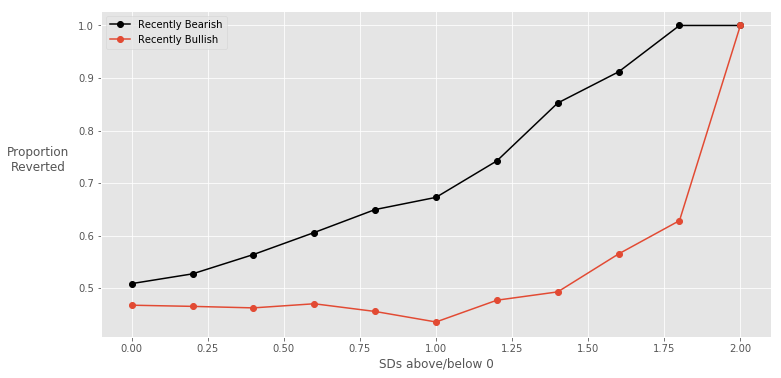

In [15]:
# with a more extreme discrimination threshold for "recently bearish/bullish", a greater proportion reverts as expected
# again, the mean reversion principle seems to hold stronger for recently bearish months, although in the most
# extreme case (2 SDs away from 0), 100% of data points revert

fig, ax = plt.subplots(1,1,figsize=(12,6))

ax.plot(Ks,reversion_proportion0,'k-o')
ax.plot(Ks,reversion_proportion1,'-o')
ax.set_ylabel('Proportion\nReverted',rotation=0,labelpad=40)
ax.set_xlabel('SDs above/below 0')
ax.legend(['Recently Bearish','Recently Bullish'])

In [16]:
# note - this corresponds to a predictive model based upon a decision tree, with the parameters defined by the 
# number of standard deviations to measure away from the mean (we've assumed the mean to be 0 here)

# (the plots above would then be the precision of the models)

In [65]:
# 'filter1' - 1 SD of "inner-noise" removed

targets_train.columns = [2]
filtered = pd.concat([features_train,targets_train],axis=1)

filtered = filtered[~((filtered[0].abs()<1.2*filtered[0].std())&(filtered[1].abs()<1.2*filtered[1].std()))]
#filtered = filtered[((filtered[0]>filtered[0].std())&(filtered[1]>filtered[1].std()))]


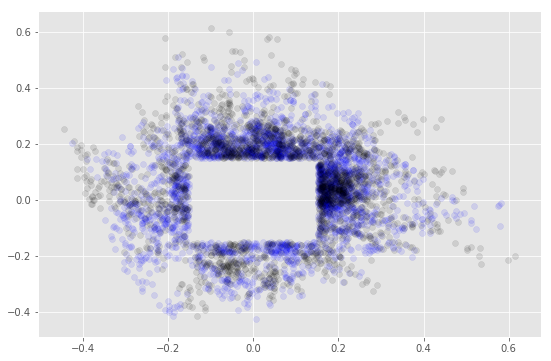

In [69]:
# weow.. directly filtering by standard deviations from each column is clearly not the most sensible approach

fig, ax = plt.subplots(1,1,figsize=(9,6))

ax.scatter(filtered[filtered[2]==1][0],filtered[filtered[2]==1][1],color='b',alpha=0.1)
ax.scatter(filtered[filtered[2]!=1][0],filtered[filtered[2]!=1][1],color='k',alpha=0.1)

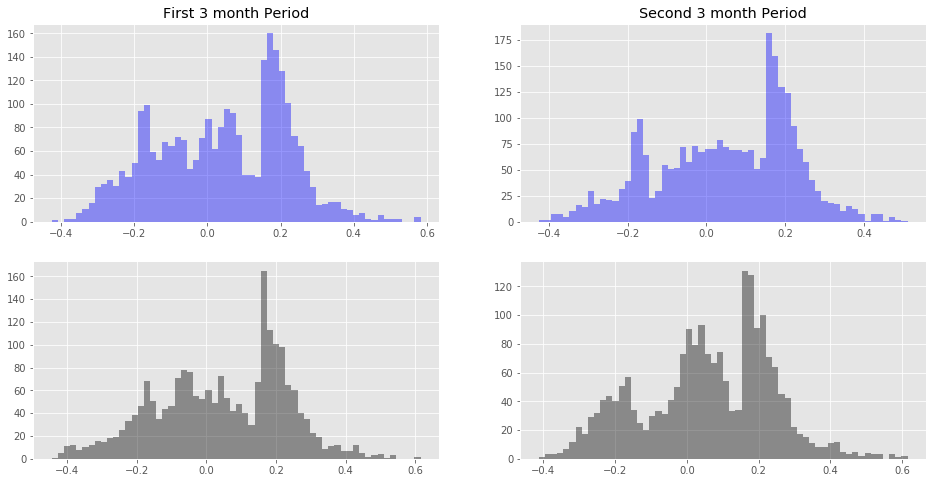

In [101]:
# distributions of net returns for each 3 month half of the 'feature window' 
# they all look distinctly non-normal 

# first row: subsequently bullish (in the walk-forward period)
# second row: subsequently bearish

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(16,8))

ax1.hist(filtered[filtered[2]==1][0].values,bins=60,color='b',alpha=0.4);
ax2.hist(filtered[filtered[2]==1][1].values,bins=60,color='b',alpha=0.4);
ax1.set_title('First 3 month Period');
ax2.set_title('Second 3 month Period');

ax3.hist(filtered[filtered[2]!=1][0].values,bins=60,color='k',alpha=0.4);
ax4.hist(filtered[filtered[2]!=1][1].values,bins=60,color='k',alpha=0.4);

In [67]:
# below is unrelated so far

In [324]:
import tensorflow as tf

model = tf.keras.Sequential()

layer_hidden_units = [2,2,2,1]

for i,hu in enumerate(layer_hidden_units):
    if i == 0: # need to specify input dimensions for the first layer
        model.add(tf.keras.layers.Dense(hu,activation='relu',input_dim=6,
                                        kernel_initializer=tf.keras.initializers.TruncatedNormal))
        continue
    if i == len(layer_hidden_units)-1: # different activation for the output layer
        model.add(tf.keras.layers.Dense(hu,activation='sigmoid'))
        continue
        
    model.add(tf.keras.layers.Dense(hu,activation='relu',kernel_initializer=tf.keras.initializers.TruncatedNormal))
    
    
model.compile(loss=tf.keras.losses.binary_crossentropy,
              optimizer=tf.keras.optimizers.SGD(lr=0.00001, momentum=0.9, nesterov=True),
              metrics=['accuracy'])

In [325]:
import time

train_acc = []
test_acc = []
iters = 300

tic = time.time()
for i in range(iters):
    model.fit(features_train.values,targets_train.values,epochs=1,batch_size=len(features_train),verbose=0)
    train_acc.append(model.evaluate(features_train.values,targets_train.values,verbose=0)[1])
    test_acc.append(model.evaluate(features_test.values,targets_test.values,verbose=0)[1])
toc = time.time()
print(toc-tic)

186.8700292110443


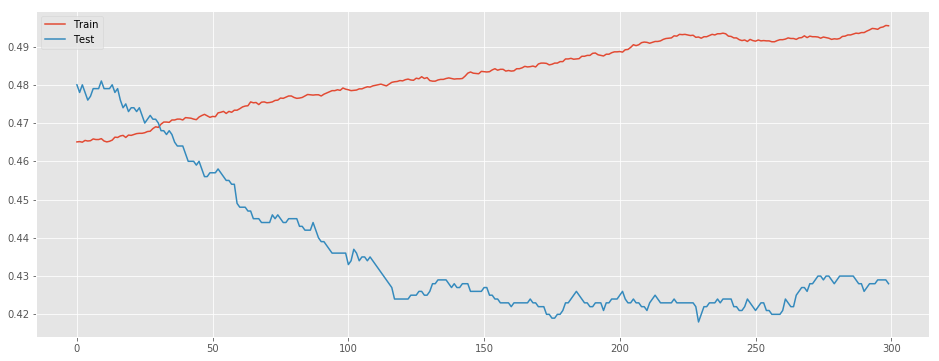

In [328]:
# performance level is not better than guessing (50-50 ish)
# test accuracy initially higher due to counts of each class (the untrained NN happens to predict more test cases correctly)

fig, ax = plt.subplots(1,1,figsize=(16,6))

ax.plot(list(range(iters)),train_acc)
ax.plot(list(range(iters)),test_acc)
ax.legend(['Train','Test'])
#ax.set_ylim([0,0.9])